In [1]:
from concurrent.futures import ProcessPoolExecutor, as_completed
import matplotlib.pyplot as plt
from debugpy.server.cli import in_range
from qutip import *
import numpy as np
import itertools
import os

# Matplotlib Einstellungen gemäß den LaTeX-Caption-Formatierungen
plt.rcParams.update({
#    'text.usetex': True,              # Enable LaTeX for text rendering
#    'font.family': 'serif',           # Use a serif font family
#    'font.serif': 'Palatino',         # Set Palatino as the serif font
#    'text.latex.preamble': r'\usepackage{amsmath}',
#    'font.size': 20,                   # Font size for general text
#    'axes.titlesize': 20,              # Font size for axis titles
#    'axes.labelsize': 20,              # Font size for axis labels
#    'xtick.labelsize': 20,             # Font size for x-axis tick labels
#    'ytick.labelsize': 20,             # Font size for y-axis tick labels
#    'legend.fontsize': 20,             # Font size for legends
#    'figure.figsize': [8, 6],          # Size of the plot (width x height)
#    'figure.autolayout': True,         # Automatic layout adjustment
#    'savefig.format': 'svg',           # Default format for saving figures
#    'figure.facecolor': 'none',        # Make the figure face color transparent
#    'axes.facecolor': 'none',          # Make the axes face color transparent
#    'savefig.transparent': True        # Save figures with transparent background
})
output_dir = os.getcwd()  # Gets the current working directory
os.makedirs(output_dir, exist_ok=True)

# allows for interactive plots
#%matplotlib notebook

$$
H = H_0 + H_I
$$

$$
H_0 = \hbar \omega_a \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} \sigma_-^{(i)} + \hbar \sum_{i,j=1}^{N_\text{{atoms}}} J_{ij} \sigma_+^{(i)} \sigma_-^{(j)} \quad \text{,} \quad J_{ij} = \frac{\alpha}{|r_i - r_j|^3}
$$

$$
H_I = \hbar D \cdot E(t)
\quad \text{,} \quad D = \mu \sum_{i=1}^{N_{\text{atoms}}} \sigma_+^{(i)} + \sigma_-^{(i)}
\quad \text{,} \quad E(t_i) \propto \Omega_{coupling} \cos(\pi (t - t_i)) \delta(t_i)
$$

### Decay operators single case
$$
C_{\text{decay}}^{(i)} = \sqrt{\gamma_0} \sigma_-^{(i)} \quad
C_{\text{dephase}}^{(i)} = \sqrt{\gamma_\phi} \sigma_z^{(i)}
$$

In [37]:
# =============================
# SYSTEM PARAMETERS
# =============================
# Energy Landscape (Natural Units: c = 1, hbar = 1)
fixed_lam = 1.0                 # Fixed wavelength (arbitrary units)
alpha = 1.0                     # Coupling strength of dipoles (Fine structure constant?)

# Atomic Parameters
omega_a = 2 * np.pi / fixed_lam # Energy splitting of the atom (ground state = 0)
mu = 1 * omega_a                # Dipole matrix element of each atom
omega_R = 1 * omega_a           # Rabi frequency coupling to laser field

# Lindblad Operators (Decay and Dephasing Rates)
gamma_0 = 0.2                   # Decay rate of the atoms
gamma_phi = 0.1                 # Dephasing rate of the atoms

# =============================
# TOPOLOGY CONFIGURATION
# =============================
n_chains = 1                    # Number of chains
n_rings = 1                     # Number of rings
N_atoms = n_chains * n_rings    # Total number of atoms
distance = 1.0                  # Distance between atoms (scaled by fixed_lam)

# =============================
# TIME EVOLUTION PARAMETERS
# =============================
t_max           = 15                    # Maximum simulation time
fine_steps      = 400                   # Number of steps for high-resolution
fine_spacing    = t_max / fine_steps    # high resolution
sparse_spacing  = 20 * fine_spacing     # for T
# Time Arrays

Delta_ts = [4*fine_spacing] * 3 # Pulse widths

times   = np.arange(0, t_max, fine_spacing)       # High-resolution times array to do the evolutions
first_entry = np.ceil((Delta_ts[1] + Delta_ts[2]) / sparse_spacing) * sparse_spacing
last_entry = np.floor((t_max - (2 * Delta_ts[0] + Delta_ts[1] + Delta_ts[2])) / sparse_spacing) * sparse_spacing
times_T = np.arange(first_entry, last_entry, sparse_spacing)

#print(first_entry, times_T)

# Gaussian Position Distribution
mean_pos = [0, 0, 0]        # Mean position (3D)
sigma_pos = N_atoms / 10    # Standard deviation for position distribution

# =============================
# GEOMETRY DEFINITIONS
# =============================
def chain_positions(distance, N_atoms):
    """ Generate atomic positions in a linear chain. """
    return np.array([[0, 0, i * distance] for i in range(N_atoms)])

def z_rotation(angle):
    """ Generate a 3D rotation matrix around the z-axis. """
    return np.array([
        [np.cos(angle), -np.sin(angle), 0],
        [np.sin(angle), np.cos(angle), 0],
        [0, 0, 1]
    ])

def ring_positions(distance, n_chains):
    """ Generate atomic positions in a ring. """
    dphi = 2 * np.pi / n_chains
    radius = 0 if n_chains == 1 else distance / (2 * np.sin(np.pi / n_chains))
    return np.array([z_rotation(dphi * i) @ [radius, 0, 0] for i in range(n_chains)])

def cyl_positions(distance, N_atoms, n_chains):
    """ Generate atomic positions in a cylindrical structure. """
    Pos_chain = chain_positions(distance, N_atoms // n_chains)
    Pos_ring = ring_positions(distance, n_chains)
    return np.vstack([Pos_chain + Pos_ring[i] for i in range(n_chains)])

# =============================
# MORE FUNCTIONS
# =============================
def sample_positions(mean_pos, sigma_pos, N_atoms):
    """ Sample random 3D positions from a Gaussian distribution. """
    return np.random.normal(loc=mean_pos, scale=sigma_pos, size=(N_atoms, 3))

def sample_frequencies(E0, Delta, N_atoms):
    """ Sample atomic frequencies from a Gaussian distribution. """
    return np.random.normal(loc=E0, scale=Delta / 2, size=N_atoms)

def plot_positive_color_map(x, y, data, T = np.inf, space="real", type="real", positive=False, safe=False):
    """
    Create a color plot of 2D functional data for positive x and y values only.

    Parameters:
        x (np.array): 1D array of x values.
        y (np.array): 1D array of y values.
        data (np.array): 2D array of data values aligned with x and y.
        T (float): Temperature parameter to include in plot title and file name.
        space (str): Either 'real' or 'freq' specifying the space of the data.
        type (str): Type of data ('real', 'imag', 'abs', or 'phase'). Used only if space="freq".
        positive (bool): Whether to use only positive values of x and y.
        safe (bool): If True, saves the plot to a file.

    Returns:
        None
    """
    # Convert x and y into 1D arrays if they're not
    x = np.array(x)
    y = np.array(y)

    if positive:
        # Filter for positive x and y values
        positive_x_indices = np.where(x > 0)[0]  # Indices where x > 0
        positive_y_indices = np.where(y > 0)[0]  # Indices where y > 0
        x = x[positive_x_indices]
        y = y[positive_y_indices]
        data = data[np.ix_(positive_y_indices, positive_x_indices)]

    label = r"$\propto E_{out} / E_0$"# \quad \propto \quad P / E_0
    if space == "real":
        colormap = "viridis"
        title = f"Real space 2D Spectrum (arb. units)"
        if T != np.inf:
            title += f" at T ={T:.2f}"
        x_title = r"$t_{det}$ (arb. units)"
        y_title = r"$\tau_{coh}$ (arb. units)"
    elif space == "freq":
        colormap = "plasma"
        if type == "real":
            title = f"Freq space, Real 2D Spectrum (arb. units)"
            data = np.real(data)
        elif type == "imag":
            title = f"Freq space, Imag 2D Spectrum (arb. units)"
            data = np.imag(data)
        elif type == "abs":
            title = f"Freq space, Abs 2D Spectrum (arb. units)"
            data = np.abs(data)
        elif type == "phase":
            title = "Freq space, Phase 2D Spectrum (arb. units)"
            data = np.angle(data)
        else:
            raise ValueError("Invalid Type. Must be 'real', 'imag', 'abs', or 'phase'.")

        if T != np.inf:
            title += f" at T ={T:.2f}"

        title += f" at T ={T:.2f}"
        x_title = r"$\omega_{t_{det}}$ (arb. units)"
        y_title = r"$\omega_{\tau_{coh}}$ (arb. units)"

    else:
        raise ValueError("Invalid space. Must be 'real' or 'freq'.")

    # Check and adjust the dimensions of x, y, and data
    if data.shape[1] != len(x):
        raise ValueError(f"Length of x ({len(x)}) must match the number of columns in data ({data.shape[1]}).")
    if data.shape[0] != len(y):
        raise ValueError(f"Length of y ({len(y)}) must match the number of rows in data ({data.shape[0]}).")

    # Add 1 to the dimensions of x and y for correct pcolormesh behavior
    x = np.concatenate([x, [x[-1] + (x[-1] - x[-2])]])  # Add an extra value for the last x edge
    y = np.concatenate([y, [y[-1] + (y[-1] - y[-2])]])  # Add an extra value for the last y edge

    # Plot the color map
    plt.figure(figsize=(8, 6))
    plt.pcolormesh(x, y, data / omega_R, shading="auto", cmap=colormap)
    plt.colorbar(label=label)
    plt.title(title)
    plt.xlabel(x_title)
    plt.ylabel(y_title)

    # Save the plot if safe is True
    if safe and output_dir is not None:
        file_name_combined = (
            f"Classical_lam{fixed_lam:.1f}_alpha={alpha:.2f}_g_0{gamma_0:.2f}_g_phi{gamma_phi:.2f}_"
            f"{n_rings}x{n_chains}_dist={distance:.2f}_positive={positive}_space={space}"
        )
        if space == "freq":
            file_name_combined += f"_type={type}"
        file_name_combined += ".svg"
        save_path_combined = os.path.join(output_dir, file_name_combined)
        plt.savefig(save_path_combined)

    plt.show()

def Hamilton0(distance, n_rings, n_chains):
    """ Construct the system Hamiltonian including dipole interactions. """
    N_atoms = n_chains * n_rings
    Pos = cyl_positions(distance, N_atoms, n_chains)
    atom_frequencies = [omega_a, 2*omega_a]# sample_frequencies(omega_a, 0.0125 * omega_a, N_atoms)
    H = 0
    for a in range(N_atoms):
        for b in range(N_atoms):
            op = sm_list[a].dag() * sm_list[b]
            if a != b:
                H += alpha / (np.linalg.norm(Pos[a] - Pos[b]))**3 * op
            else:
                H += atom_frequencies[a] * op
    return H

def get_times_for_T(T, spacing=fine_spacing):
    # Adjust the first and last entries of times_tau
    first_tau = np.ceil((Delta_ts[0] + Delta_ts[1]) / spacing) * spacing
    last_tau = np.floor((t_max - Delta_ts[2] - T - Delta_ts[0]) / spacing) * spacing
    times_tau = np.arange(first_tau, last_tau, spacing)
    # Adjust the first and last entries of times_t
    first_t = np.ceil(Delta_ts[2] / spacing) * spacing
    last_t = np.floor((t_max - Delta_ts[0] - T - 2 * Delta_ts[2]) / spacing) * spacing
    times_t = np.arange(first_t, last_t, spacing)

    return times_tau, times_t
for i in range(len(times_T)):  # Use range to iterate over indices
    # Get the result once and store it in a variable
    result = get_times_for_T(times_T[i])

    # Unpack the result for easier access
    first_set = result[0]
    second_set = result[1]

    ## Print the desired elements from the result in a formatted manner
    #print(f"Time index {i}:")
    #print(f"  First set: {first_set[0]} {first_set[1]} {first_set[-1]}, {len(first_set)* sparse_spacing}")
    #print(f"  Second set: {second_set[0]} {second_set[1]} {second_set[-1]}, {len(first_set)* sparse_spacing}")
    #print("-" * 40)  # Separator for better readability between each iteratio

# =============================
# TIME-DEPENDENT FIELD
# =============================
def El_field(t, args):
    """ Define a time-dependent electric field pulse. """
    t0, Delta, omega, phi, E0 = args['time'], args['Delta'], args['omega'], args['phi'], args['E0']
    E = np.exp(1j * (omega * t + phi))
    E += np.conjugate(E)
    E *= np.cos(np.pi * (t - t0) / (2 * Delta))**2 * np.heaviside(t - (t0 - Delta), 0) * np.heaviside(t0 + Delta - t, 0)
    return E0 * E

# =============================
# QUANTUM SYSTEM INITIALIZATION
# =============================
# Define Atomic States
atom_g = basis(N_atoms + 1, 0)                                      # Ground state
atom_es = [basis(N_atoms + 1, i) for i in range(1, N_atoms + 1)]    # Excited states
psi_ini = ket2dm(atom_g)                                                     # Initial state = ground state

# Define Lowering Operators
sm_list = [atom_g * atom_es[i].dag() for i in range(N_atoms)]
Dip_op = sum(mu * (op + op.dag()) for op in sm_list)                # Collective dipole operator

# Define System Hamiltonian
H0 = Hamilton0(distance, n_rings, n_chains)

# =============================
# COLLAPSE OPERATORS
# =============================
c_op2 = [np.sqrt(gamma_0) * op for op in sm_list]                           # Atomic decay operators
c_op4 = [np.sqrt(gamma_phi) * commutator(op.dag(), op) for op in sm_list]   # Dephasing operators
c_op_list = c_op2 + c_op4                                                   # Combine collapse operators

e_op_list = [ket2dm(basis(N_atoms + 1, i)) for i in range(N_atoms + 1)]     # Expectation operators


# =============================
# SYSTEM EVOLUTION
# =============================
Omegas = [omega_R, omega_R, omega_R * 1e-2]   # Rabi frequencies
omegas = [omega_a] * 3                      # Laser frequencies (on resonance)

HI = [-Dip_op, El_field]                    # Interaction Hamiltonian
H = [H0, HI]

options = Options(store_states=True)        # safe the states from qutip calculation

# Phase Cycling for Averaging
phases = [0]#[-i * np.pi / 2 for i in range(4)] # GIVES WEIRD RESULTS

# Display the results
#print("First entry:", first_entry)
#print("Last entry:", last_entry)
#print("Times array:", times_T)

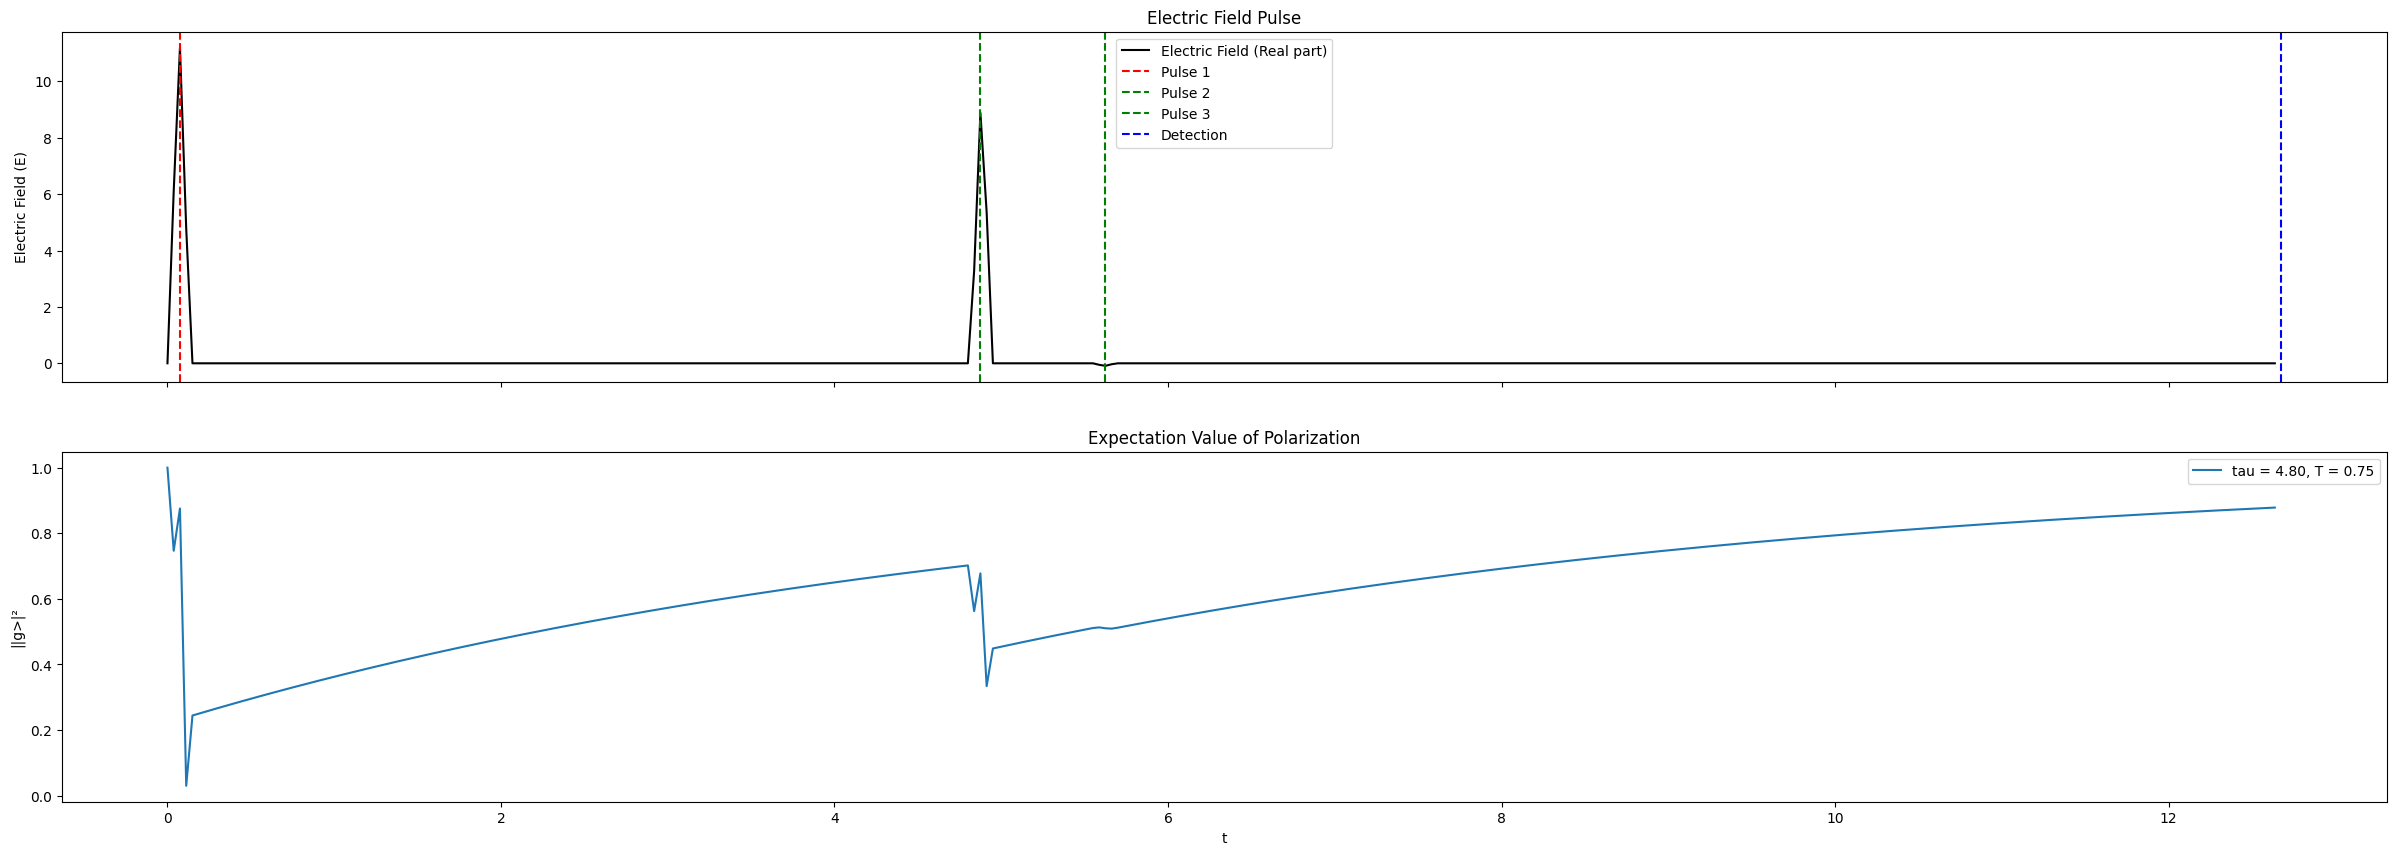

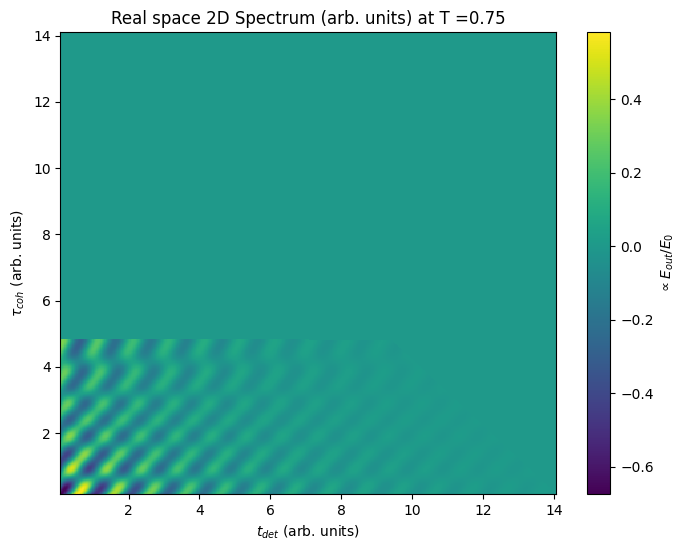

In [38]:
## Calculations

### Compute Pulse
def compute_pulse(psi_ini, times, phi, i):
    args = {
        'phi': phi,
        'time': times[0] + Delta_ts[i],
        'omega': omegas[i],
        'Delta': Delta_ts[i],
        'E0': Omegas[i]
    }
    result = mesolve(H, psi_ini, times, c_ops=c_op_list, e_ops=e_op_list, args=args, options=options)
    return result

### Compute Two-Dimensional Polarization
def compute_two_dimensional_polarization(T_val, phi_1, phi_2):
    tau_values, t_values = get_times_for_T(T_val)
    data = np.zeros((len(tau_values), len(t_values)))

    index_0 = np.abs(times - (tau_values[-1] - Delta_ts[1] + Delta_ts[0])).argmin()  # Find the closest index to reduce computation time
    times_0 = times[:index_0+1] - times[0]


    data_1 = compute_pulse(psi_ini, times_0, phi_1, 0)

    for tau_idx, tau in enumerate(tau_values):
        i = np.abs(tau_values[tau_idx] - (times_0 + Delta_ts[1] - Delta_ts[0])).argmin()
        psi_1 = data_1.states[i]

        index_1 = np.abs(times - (times_0[i] + T_val - Delta_ts[1] + Delta_ts[2])).argmin()  # Find the closest index to reduce computation time
        times_1 = times[i:index_1+1] - times[i]

        data_2 = compute_pulse(psi_1, times_1, phi_2, 1)

        j = np.abs(T_val - (times_1 + Delta_ts[2] - Delta_ts[1])).argmin()

        psi_2 = data_2.states[j]
        times_2 = times[j:] - times[j]

        data_f = compute_pulse(psi_2, times_2, 0, 2)

        for t_idx, t in enumerate(t_values):
            if t + T_val + tau + Delta_ts[0] < t_max:

                k = np.abs(t_values[t_idx] - (times_2 - Delta_ts[2])).argmin()
                psi_f = data_f.states[k]
                data[tau_idx, t_idx] = expect(Dip_op, psi_f)

                # make one plot for this case
                if tau == tau_values[len(tau_values)//3] and t == t_values[len(t_values)//2]:
                    times_plot = times[:i+j+k]  # Use t_values for the x-axis

                    args0 = {
                        'phi': phi_1,
                        'time': times_0[0] + Delta_ts[0],
                        'omega': omegas[0],
                        'Delta': Delta_ts[0],
                        'E0': Omegas[0]
                    }
                    args1 = {
                        'phi': phi_2,
                        'time': times_0[i] + Delta_ts[1],
                        'omega': omegas[1],
                        'Delta': Delta_ts[1],
                        'E0': Omegas[1]
                    }
                    args2 = {
                        'phi': 0,
                        'time': times_0[i] + times_1[j] + Delta_ts[2],
                        'omega': omegas[2],
                        'Delta': Delta_ts[2],
                        'E0': Omegas[2]
                    }

                    concatenated_data = []

                    # Concatenate the data for different segments
                    concatenated_data.append(data_1.expect[0][:i])  # First part (data_1)
                    concatenated_data.append(data_2.expect[0][:j])  # Second part (data_2)
                    concatenated_data.append(data_f.expect[0][:k])  # Final part (data_f)

                    # Concatenate all parts together
                    full_expectation_values = np.concatenate(concatenated_data)
                    fig, axs = plt.subplots(2, 1, figsize=(30, 10), sharex=True)

                    E_total = [(El_field(t, args0) + El_field(t, args1) + El_field(t, args2)) for t in times_plot]
                    axs[0].plot(times_plot, E_total, label='Electric Field (Real part)', color='black')
                    axs[0].set_ylabel('Electric Field (E)')
                    axs[0].set_title('Electric Field Pulse')

                    # Add vertical lines to mark pulse times
                    axs[0].axvline(times_0[0] + Delta_ts[0], color='r', linestyle='--', label='Pulse 1')
                    axs[0].axvline(times_0[i] + Delta_ts[1], color='g', linestyle='--', label='Pulse 2')
                    axs[0].axvline(times_0[i] + times_1[j] + Delta_ts[2], color='g', linestyle='--', label='Pulse 3')
                    axs[0].axvline(times_0[i] + times_1[j] + times_2[k], color='b', linestyle='--', label='Detection')
                    axs[0].legend()

                    # Plot Expectation Value in the second subplot
                    axs[1].plot(times_plot, full_expectation_values, label=f'tau = {tau:.2f}, T = {T_val:.2f}')
                    axs[1].set_xlabel('Time (t)')
                    axs[1].set_ylabel('Expectation Value (||g>|²)')
                    axs[1].set_title('Expectation Value of Polarization')

                    # Add labels and legend
                    plt.xlabel(r't')
                    plt.ylabel(r'||g>|²')
                    plt.legend()
                    plt.show()

                    return tau_values, t_values, data

### Test Computation
T_test = times_T[0]
data_test_0 = compute_two_dimensional_polarization(T_test, phases[0], phases[0])
plot_positive_color_map(data_test_0[1], data_test_0[0], data_test_0[2], T=T_test, safe=False)

In [39]:
def process_phi_combination(phi_1, phi_2, times_T):
    # Preallocate an array to store results for each T in times_T
    full_data_array = np.empty((len(times_T)), dtype=object)

    # Using ProcessPoolExecutor to parallelize the inner loop
    with ProcessPoolExecutor() as executor:
        futures = []
        for i in range(len(times_T)):
            futures.append(executor.submit(compute_two_dimensional_polarization, times_T[i], phi_1, phi_2))

        # Collect results as they complete
        for i, future in enumerate(as_completed(futures)):
            full_data_array[i] = future.result()

    return full_data_array

# Function to handle parallel processing for each phi1, phi2 combination
def parallel_process_all_combinations(phases, times_T):
    all_results = {}

    # Use ProcessPoolExecutor for outer loop
    with ProcessPoolExecutor() as executor:
        futures = []

        # Submit all phi1, phi2 combinations as separate tasks
        for phi1, phi2 in itertools.product(phases, phases):
            future = executor.submit(process_phi_combination, phi1, phi2, times_T)
            futures.append((future, phi1, phi2))  # Store both the future and the corresponding (phi1, phi2)

        # Collect the results
        for future, phi1, phi2 in futures:
            all_results[(phi1, phi2)] = future.result()  # Store the result in the dictionary

    return all_results

# Call the function to parallelize the whole process
all_results = parallel_process_all_combinations(phases, times_T)

In [40]:
# Iterate over all results and sort based on the length of tau_values
sorted_results = {}

for (phi1, phi2), result in all_results.items():
    sorted_combination = []

    sorted_result = sorted(result, key=lambda data_item: len(data_item[0]), reverse=True)
    sorted_result = sorted_result[:-1]
    sorted_results[(phi1, phi2)] = sorted_result
    #plot_positive_color_map(sorted_result[1][1], sorted_result[1][0], sorted_result[1][2], times_T[i])

In [43]:
# the time data can even be padded
def average_and_plot_results(results, times_T):
    num_combinations = len(results)  # Number of (phi1, phi2) pairs
    num_time_steps = len(times_T)-1  # Number of time indices

    # Initialize an array to store averaged data for each time step
    averaged_data_array = np.empty(num_time_steps, dtype=object)

    for i in range(num_time_steps):  # Loop over time indices
        sum_data = None  # Placeholder for summing data arrays
        ts, taus = None, None  # Will store time axes from any valid entry

        # Sum over all (phi1, phi2) combinations
        for _, full_data_array in results.items():
            ts, taus, data_time = full_data_array[i]  # Extract data
            if sum_data is None:
                sum_data = np.zeros_like(data_time)  # Initialize sum with correct shape

            sum_data += data_time  # Accumulate data

        # Compute the average
        averaged_data = sum_data / num_combinations

        # Now pad the averaged_data, ts, and taus
        # First, calculate the desired padded size
        pad_val = 1 #>= 1
        padded_size = (int(np.round(averaged_data.shape[0] * pad_val)), int(np.round(averaged_data.shape[1] * pad_val)))

        # Pad averaged_data to twice the size
        padded_averaged_data = np.pad(averaged_data,
                                      ((0, padded_size[0] - averaged_data.shape[0]),
                                       (0, padded_size[1] - averaged_data.shape[1])),
                                      mode='constant', constant_values=0)  # Use 0 for padding

        # Extend ts and taus to match the padded size
        padded_ts = np.linspace(ts[0], np.round(ts[-1] * pad_val), padded_size[1])
        padded_taus = np.linspace(taus[0], np.round(taus[-1] * pad_val), padded_size[0])

        # Store the padded results
        averaged_data_array[i] = (padded_ts, padded_taus, padded_averaged_data)

        # Optionally plot the padded results
        #plot_positive_color_map(padded_ts, padded_taus, padded_averaged_data, times_T[i])
    #plot_positive_color_map(averaged_data_array[1][1], averaged_data_array[1][0], averaged_data_array[1][2], times_T[i])

    return averaged_data_array  # Return for further processing if needed

# Call the function
averaged_results = average_and_plot_results(sorted_results, times_T)

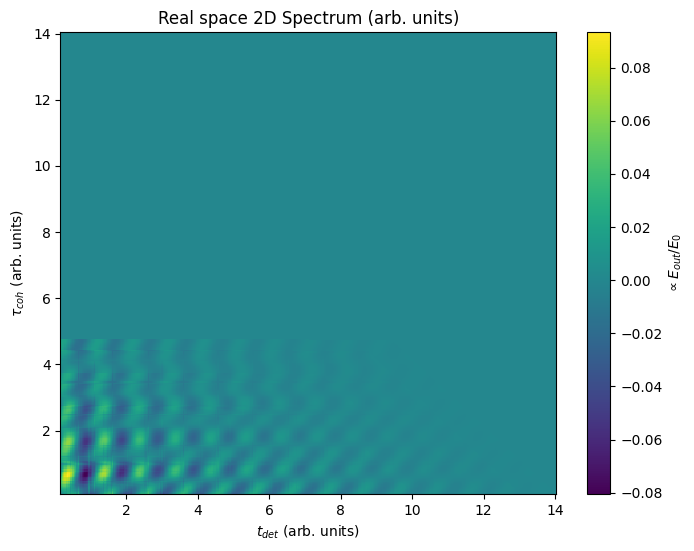

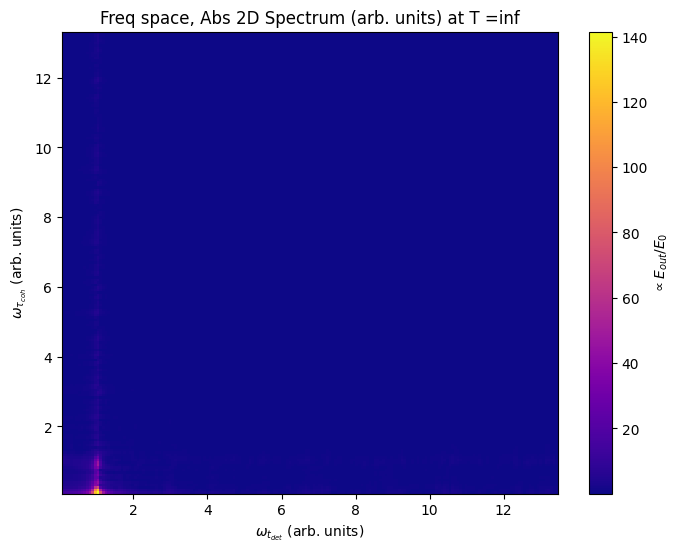

In [44]:
def extend_and_transform_averaged_results(averaged_results):
    """ Extend the first data set (i=0) to all averaged results and compute FFT """

    # 1. Define global time and frequency axes based on the first dataset
    global_taus = averaged_results[0][1]  # Global taus (excitation time)
    global_ts = averaged_results[0][0]  # Global ts (detection time)

    # Compute frequency axes for FFT
    global_t_freqs = np.fft.fftfreq(len(global_ts), d=(global_ts[1] - global_ts[0]))
    global_tau_freqs = np.fft.fftfreq(len(global_taus), d=(global_taus[1] - global_taus[0]))

    # Initialize zero arrays for global time and frequency domain results
    global_data_time = np.zeros((len(global_taus), len(global_ts)))
    global_data_freq = np.zeros((len(global_taus), len(global_ts)), dtype=np.complex64)

    # 2. Iterate over the averaged results
    def find_closest_index(local_times, global_times):
        # Find the index in global_times for each time in local_times that is closest
        closest_indices = []
        for local_time in local_times:
            # Calculate the absolute differences
            differences = np.abs(global_times - local_time)
            # Find the index with the minimum difference
            closest_idx = np.argmin(differences)
            closest_indices.append(closest_idx)

        return closest_indices

    #print("Global ts:", global_ts[0], global_ts[1])
    #print("Global taus:", global_taus[0], global_taus[1])
    # Example usage
    for i, (ts, taus, data_time) in enumerate(averaged_results):
        # Create an extended data array matching global grid
        data_extended_time = np.zeros_like(global_data_time)

        # Find closest indices in global_taus and global_ts
        tau_indices = find_closest_index(taus, global_taus)
        t_indices = find_closest_index(ts, global_ts)

        # Now map the local data_time to the global grid
        for local_tau_idx, global_tau_idx in enumerate(tau_indices):
            for local_t_idx, global_t_idx in enumerate(t_indices):
                data_extended_time[global_tau_idx, global_t_idx] = data_time[local_tau_idx, local_t_idx]        # Compute FFT of the extended time data
        data_extended_freq = np.fft.fft2(data_extended_time)

        # Accumulate results
        global_data_time += data_extended_time
        global_data_freq += data_extended_freq

        # Plot intermediate results for each time step
        #plot_positive_color_map(ts, taus, data_time, times_T[i])
        #plot_positive_color_map(global_ts, global_taus, data_extended_time, times_T[i])
        #plot_positive_color_map(global_t_freqs, global_tau_freqs, data_extended_freq, times_T[i], space= "freq", positive = True, type="real")
        #plot_positive_color_map(global_ts, global_taus, global_data_time, times_T[i], safe=False)  # Time-space data

    global_data_time /= len(averaged_results)
    global_data_freq /= len(averaged_results)

    # 3. Plot final aggregated results
    plot_positive_color_map(global_ts, global_taus, global_data_time, safe=False)  # Time-space data
    plot_positive_color_map(global_t_freqs, global_tau_freqs, global_data_freq, space="freq", type="abs", positive=True, safe=False)  # Frequency-space data

    return global_data_time, global_data_freq  # Return for further processing if needed

# Call the function
global_time_result, global_freq_result = extend_and_transform_averaged_results(averaged_results)